In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_columns', None)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, classification_report, recall_score

from mlxtend.plotting import plot_decision_regions

In [2]:
df_diab = pd.read_csv('data/diabetes_data.csv')
df_heart = pd.read_csv('data/heart_disease_data.csv')

In [3]:
df_heart.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,IsMale
0,40,True,289,False,172,False,0.0,1,False,False,True,False,False,False,True,False,True
1,49,True,180,False,156,False,1.0,0,True,False,False,True,False,False,True,False,False
2,37,True,283,False,98,False,0.0,1,False,False,True,False,False,False,False,True,True
3,48,True,214,False,108,True,1.5,0,True,True,False,False,False,False,True,False,False
4,54,True,195,False,122,False,0.0,1,False,False,False,True,False,False,True,False,True


In [4]:
df_diab.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income,IsMale,Diabetes
0,False,False,False,66.0,False,False,False,False,True,True,False,True,False,5.0,0.0,30.0,True,9.0,4.0,5.0,False,True
1,False,False,False,34.0,False,False,False,True,False,True,False,True,False,3.0,0.0,0.0,False,7.0,6.0,8.0,False,True
2,False,False,False,30.0,False,False,False,True,True,True,False,True,False,3.0,0.0,2.0,False,6.0,6.0,8.0,True,True
3,False,False,False,39.0,False,False,False,True,True,True,False,True,False,2.0,2.0,10.0,True,4.0,5.0,5.0,False,True
4,False,False,False,37.0,True,False,False,False,False,True,False,True,False,2.0,0.0,0.0,False,7.0,6.0,7.0,True,True


# Algorithms to Explore
* Decision Trees (with pruning)
* Neural Network
* Boosting (GB)
* SVM
* kNN

In [5]:
X_diab = df_diab.drop('Diabetes', axis=1)
y_diab = df_diab['Diabetes']

X_train_diab, X_test_diab, y_train_diab, y_test_diab = train_test_split(X_diab, y_diab, random_state=0)

In [6]:
X_heart = df_heart.drop('HeartDisease', axis=1)
y_heart = df_heart['HeartDisease']

X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(X_heart, y_heart, random_state=0)

In [7]:
def knn_validation(X_train, y_train, X_test, y_test, param, min_val, max_val, step=1, params={}):
    scores = []
    best_score = 0
    values = [val for val in np.arange(min_val, max_val + 1, step)]
    for value in values:
        params.update({param: value})
        knn = KNeighborsClassifier(**params)
        knn.fit(X_train, y_train)
        cur_score = get_recall(knn, X_test, y_test)
        scores.append(cur_score)
        if cur_score > best_score:
            best_score = cur_score
            print(f'best score: {best_score} --- {param}: {value}', end='\r')
    print(end='\n')
    return scores, values

In [8]:
def knn_validation_cats(X_train, y_train, X_test, y_test, param, values, params={}):
    scores = []
    best_score = 0
    for value in values:
        params.update({param: value})
        knn = KNeighborsClassifier(**params)
        knn.fit(X_train, y_train)
        cur_score = get_recall(knn, X_test, y_test)
        scores.append(cur_score)
        if cur_score > best_score:
            best_score = cur_score
            print(f'best score: {best_score} --- {param}: {value}', end='\r')
    print(end='\n')
    return scores, values

In [9]:
def get_recall(model, X_test, y_test):
    y_pred = model.predict(X_test)
    recall = classification_report(y_test, y_pred, output_dict=True)['True']['recall']
    return recall

In [10]:
knn_baseline_diab = KNeighborsClassifier()
knn_baseline_diab.fit(X_train_diab, y_train_diab)
print('diabetes baseline score:', get_recall(knn_baseline_diab, X_test_diab, y_test_diab))

diabetes baseline score: 0.7222398981864461


In [11]:
knn_baseline_heart = KNeighborsClassifier()
knn_baseline_heart.fit(X_train_heart, y_train_heart)
print('heart disease baseline score:', get_recall(knn_baseline_heart,X_test_heart, y_test_heart))

heart disease baseline score: 0.7058823529411765


Diabetes
best score: 0.7839643652561247 --- n_neighbors: 90

Heart Disease
best score: 0.6974789915966386 --- n_neighbors: 18


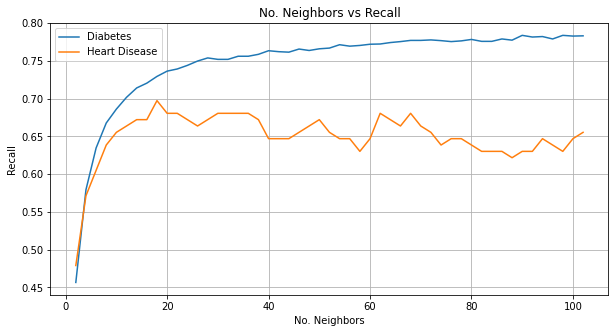

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
print('Diabetes')
diab_k_scores, diab_k_values = knn_validation(X_train_diab, y_train_diab, 
                                                   X_test_diab, y_test_diab,
                                                   'n_neighbors', 2, 102, 2)
print('\nHeart Disease')
heart_k_scores, heart_k_values = knn_validation(X_train_heart, y_train_heart, 
                                                     X_test_heart, y_test_heart,
                                                     'n_neighbors', 2, 102, 2)
ax.plot(diab_k_values, diab_k_scores, label='Diabetes')
ax.plot(heart_k_values, heart_k_scores, label='Heart Disease')
ax.grid()
ax.set_xlabel('No. Neighbors')
plt.legend()
ax.set_title('No. Neighbors vs Recall')
ax.set_ylabel('Recall');

In [13]:
error_rate_diab = []
for i in np.arange(2,103, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_diab ,y_train_diab )
    pred_i = knn.predict(X_test_diab)
    error_rate_diab.append(np.mean(pred_i != y_test_diab))
    
    
error_rate_heart = []
for i in np.arange(2,103, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_heart ,y_train_heart )
    pred_i = knn.predict(X_test_heart)
    error_rate_heart.append(np.mean(pred_i != y_test_heart))

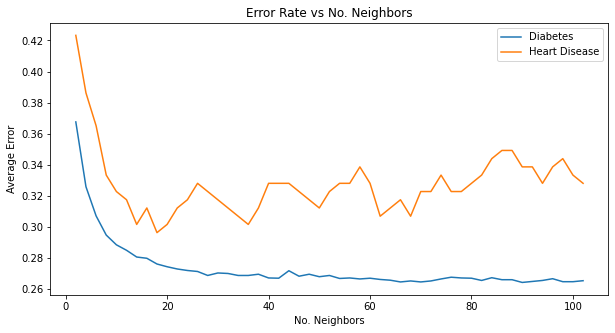

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(2, 103, 2), error_rate_diab, label='Diabetes')
ax.plot(np.arange(2, 103, 2), error_rate_heart, label='Heart Disease')
ax.set_xlabel('No. Neighbors')
ax.set_ylabel('Average Error')
plt.legend()
ax.set_title('Error Rate vs No. Neighbors');

Diabetes
best score: 0.7664651606745148 --- algorithm: auto

Heart Disease
best score: 0.7394957983193278 --- algorithm: auto


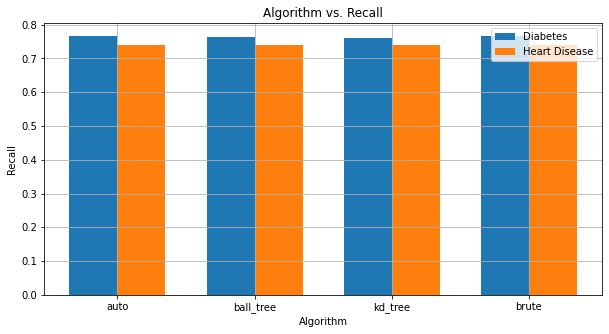

In [15]:
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
fig, ax = plt.subplots(figsize=(10,5))
print('Diabetes')
diab_kernel_scores, diab_kernel_values = knn_validation_cats(X_train_diab, y_train_diab, 
                                                             X_test_diab, y_test_diab,
                                                             'algorithm', algorithms, params={'n_neighbors':19})
print('\nHeart Disease')
heart_kernel_scores, heart_kernel_values = knn_validation_cats(X_train_heart, y_train_heart, 
                                                               X_test_heart, y_test_heart,
                                                               'algorithm', algorithms, params={'n_neighbors':15})
x = np.arange(len(algorithms))  # the label locations
width = 0.35  # the width of the bars
ax.bar(x - width/2, diab_kernel_scores, width, label='Diabetes')
ax.bar(x + width/2, heart_kernel_scores, width, label='Heart Disease')
ax.grid()
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.set_xlabel('Algorithm')
ax.set_title('Algorithm vs. Recall')
plt.legend()
ax.set_ylabel('Recall');

In [16]:
diab_params = {'n_neighbors':19}
diab_knn = KNeighborsClassifier(**diab_params)
diab_knn.fit(X_train_diab, y_train_diab)
get_recall(diab_knn, X_test_diab, y_test_diab)

0.7664651606745148

In [17]:
heart_params = {'n_neighbors':15}
heart_knn = KNeighborsClassifier(**heart_params)
heart_knn.fit(X_train_heart, y_train_heart)
get_recall(heart_knn, X_test_heart, y_test_heart)

0.7394957983193278

In [18]:
import json
with open('params/knn_params.json', 'w') as f:
    params = {'diab':diab_params, 'heart':heart_params}
    json.dump(params, f)